<html>
<div>
  <img src="https://static.thenounproject.com/png/1657077-200.png" width=auto style="vertical-align: middle;">
</div>
</html>

University of Tehran   
DS - CA0  
Spring 03  

Shahriar Attar: 810100186  
Pasha Brahimi: 810199xxx  
Mobina Mehrazar: 810100216

# Web Scraping and Introductory Data Analysis

Welcome to Homework 0, where we will delve into web scraping and perform an introductory data analysis. This homework will be a hands-on exercise that will help you become familiar with the process of extracting data from websites and conducting basic statistical analysis.

## Objectives

By the end of this homework, you will be able to:

1. Set up a Python environment with the necessary libraries for web scraping and data analysis.
2. Write a web scraping script using Beautiful Soup and Selenium to collect data from a website.
3. Sample from the collected dataset and compare the statistics of the sample and the population.

## Tasks

1. **Environment Setup**: Install the required libraries such as Beautiful Soup, Selenium, pandas, numpy, matplotlib, and seaborn.

2. **Web Scraping**: Write a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs). Use Selenium to interact with the website and Beautiful Soup to parse the HTML content.

3. **Data Sampling**: Once the data is collected, create a sample from the dataset. Compare the sample statistics (mean and standard deviation) with the population statistics.


## Getting Started

Begin by setting up your Python environment and installing the necessary libraries. Then, proceed with the web scraping task, ensuring that you handle any potential issues such as rate limiting. Once you have the data, move on to the data sampling and statistical analysis tasks.

Remember to document your process and findings in the Jupyter notebook, and to include visualizations where appropriate to illustrate your results. <br>
Good luck, and happy scraping!

In [62]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import csv

In [ ]:
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager

# ** Chrome
# driver = webdriver.Chrome(ChromeDriverManager().install()) # If you don't have the chromedriver installed, it will install it for you
# driver = webdriver.Chrome() # If you have the chromedriver installed, you can use this line


# ** Firefox 
# driver = webdriver.Firefox(GeckoDriverManager().install()) # If you don't have the geckodriver installed, it will install it for you
driver = webdriver.Firefox() # If you have the geckodriver installed, you can use this line

In [58]:
SCRAPE_URL = "https://etherscan.io/txs"
SCRAPE_BLOCKS = 10
TRANSACTIONS_CSV = "../data/transactions.csv"
TRANSACTIONS_CLEANED_CSV = "../data/transactions_cleaned.csv"
SAMPLE_PROPORTION = 0.1
RANDOM_SEED = 42

## Data Collection (Etherscan)

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Considerations

-   **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary. For this we can use `time.sleep()` to add a delay between requests, but 
  
-   **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data. We can use `Selenium`'s `WebDriverWait` to wait for the elements to load before scraping the data and use `expected_conditions` to specify what we are waiting for, also some duplications may occur in the data, so we need to remove them.
  
-   **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.


### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

In [ ]:
driver.get(SCRAPE_URL)

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

In [12]:
def parse_transactions(page_source: str) -> list[dict[str, str]]:
    soup = BeautifulSoup(page_source, "html.parser")
    table = soup.find("table", {"class": "table table-hover table-align-middle mb-0"})
    body = table.find("tbody")
    rows = body.find_all("tr")
    transactions : list[dict[str, str]] = []
    for row in rows:
        cells = row.find_all("td")
        if len(cells) > 0:
            transaction = {
                "Txn Hash": cells[1].text.strip(),
                "Method": cells[2].text.strip(),
                "Block": cells[3].text.strip(),
                "Timestamp": cells[4].text.strip(),
                "Age": cells[5].text.strip(),
                "From": cells[7].text.strip(),
                "To": cells[9].text.strip(),
                "Value": cells[10].text.strip(),
                "Txn Fee": cells[11].text.strip(),
            }
            transactions.append(transaction)
    return transactions

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data. A problem that we encountered way that the website has a dynamic loading system, when we go to the next page, some new transactions were loaded so some entries were duplicated. We solved this later in data cleaning.

In [13]:
last_block = None
first_block = None
transactions : list[dict[str, str]] = []

while True:
    transactions += parse_transactions(driver.page_source)

    if first_block is None:
        last_block = int(transactions[0]["Block"])
        first_block = last_block - SCRAPE_BLOCKS + 1

    if int(transactions[-1]["Block"]) < first_block:
        break

    driver.find_element(By.LINK_TEXT, "Next").click()

driver.close()

In [17]:
print(f"Scraped {len(transactions)} transactions from blocks {first_block} to {last_block}")
print(transactions[0])
print(transactions[-1])

Scraped 4700 transactions from blocks 19334507 to 19334516
{'Txn Hash': '0x87ad207685a04a5630df4dc60f691b3e6679896f1def7d3c5a8af8600be9e1c0', 'Method': 'Sell To Uniswap', 'Block': '19334516', 'Timestamp': '2024-02-29 16:59:47', 'Age': '11 secs ago', 'From': '0xD11c274E...100D7A541', 'To': '0x: Exchange Proxy', 'Value': '0.581130968 ETH', 'Txn Fee': '0.00967144'}
{'Txn Hash': '0xd57fcd1d504476c3d9daad2f5cacb5fb142aba92c9b71a1c54cdcc6f2f14e6f0', 'Method': 'Transfer', 'Block': '19334506', 'Timestamp': '2024-02-29 16:57:47', 'Age': '5 mins ago', 'From': '0x3E56a0C8...15B4f89D0', 'To': 'Tether: USDT Stablecoin', 'Value': '0 ETH', 'Txn Fee': '0.00316241'}


5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

In [26]:
with open(TRANSACTIONS_CSV, "w", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=transactions[0].keys(), lineterminator='\n')
    writer.writeheader()
    writer.writerows(transactions)

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.


In [67]:
df = pd.read_csv(TRANSACTIONS_CSV)
df.head()

,Txn Hash,Method,Block,Timestamp,Age,From,To,Value,Txn Fee
0,0x87ad207685a04a5630df4dc60f691b3e6679896f1def...,Sell To Uniswap,19334516,2024-02-29 16:59:47,11 secs ago,0xD11c274E...100D7A541,0x: Exchange Proxy,0.581130968 ETH,0.009671
1,0x3fb7613717d61a3f6bf330c542e061463aa1868aa24a...,Transfer,19334516,2024-02-29 16:59:47,11 secs ago,0x9c95822B...53D8C79a3,VAIOT: VAI Token,0 ETH,0.002132
2,0x341367774a838fee5d7c7465b9eb151ddbe012dce6de...,Sell To Uniswap,19334516,2024-02-29 16:59:47,11 secs ago,0x3b454995...7500236a3,0x: Exchange Proxy,0.016822346 ETH,0.008656
3,0x9317998e91e7ad56cf0bab4927a425a56ec493243c03...,Transfer,19334516,2024-02-29 16:59:47,11 secs ago,0x37A653a8...8B8b0CFCC,0x57A54b0A...94f9DD578,0.003698047 ETH,0.001506
4,0x87c23770735932244ced56868f2387123505922c42b4...,Execute,19334516,2024-02-29 16:59:47,11 secs ago,0x73491B6d...1CdD889C9,Uniswap: Universal Router,0.08 ETH,0.011457


2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.

In [68]:
# Calculate the first and last block numbers as we may use the csv instead of scraping
last_block = int(df["Block"].iloc[0])
first_block = last_block - SCRAPE_BLOCKS + 1

df = df[df["Block"].between(first_block, last_block)]

In [69]:
# Remove duplicate transactions as we may have scraped the same transaction multiple times due to pagination
df = df.drop_duplicates(subset=["Txn Hash"], keep="first", ignore_index=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Txn Hash   1883 non-null   object 
 1   Method     1883 non-null   object 
 2   Block      1883 non-null   int64  
 3   Timestamp  1883 non-null   object 
 4   Age        1883 non-null   object 
 5   From       1883 non-null   object 
 6   To         1883 non-null   object 
 7   Value      1883 non-null   object 
 8   Txn Fee    1883 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 132.5+ KB


In [71]:
df[~df["Value"].str.contains("ETH")]

,Txn Hash,Method,Block,Timestamp,Age,From,To,Value,Txn Fee
834,0x7bd7632e58f8c5abbad7cc8f5138b5e17da30370fc9f...,0x020965d0,19334512,2024-02-29 16:58:59,2 mins ago,0xD267fdA7...284b72dA9,Seawise: Resolver,77 wei,0.027082


Some values are in wei, kwei, mwei, gwei, etc. We need to drop those data points 

In [72]:
df = df[df["Value"].str.contains("ETH")]

The values have an 'ETH' suffix. We need to remove the ETH suffix and convert the object dtype into float64


In [73]:
def convert_values_to_float(value):
    return float(value.replace("ETH", ""))
df["Value"] = df["Value"].apply(convert_values_to_float)


In [74]:
any_missing_values = df.isnull().any().any()
print(f"Is there some missing values in this dataframe? {any_missing_values}")

Is there some missing values in this dataframe? False


Since we have `TimeStamp` column, we can convert it to a datetime object, and we can get rid of the `Age` column.

In [75]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.drop(columns=["Age"])

Parsing `Method` Column

In [76]:
def categorize_method(method):
    if 'Sell' in method:
        return 'Sell'
    elif 'Transfer' in method:
        return 'Transfer'
    elif 'Execute' in method:
        return 'Execute'
    elif 'Approve' in method:
        return 'Approve'
    else:
        return 'Other'
    
df['Method'] = df['Method'].apply(categorize_method)

Removing outliers for `Value` and `TxnFee` columns

In [77]:
z_scores_value = stats.zscore(df['Value'])
z_scores_txn_fee = stats.zscore(df['Txn Fee'])

threshold = 3

df = df[(np.abs(z_scores_value) < threshold) & (np.abs(z_scores_txn_fee) < threshold)]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1842 entries, 0 to 1882
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Txn Hash   1842 non-null   object        
 1   Method     1842 non-null   object        
 2   Block      1842 non-null   int64         
 3   Timestamp  1842 non-null   datetime64[ns]
 4   From       1842 non-null   object        
 5   To         1842 non-null   object        
 6   Value      1842 non-null   float64       
 7   Txn Fee    1842 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 129.5+ KB


In [79]:
df.to_csv(TRANSACTIONS_CLEANED_CSV, index=False)

3. **Statistical Analysis**: Calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.

4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. Provide an explanation on the bin size selection!
    - A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.
    - A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.

In [80]:
def count_values_in_column(df, column_name):
    return df[column_name].value_counts()

def plot_distributions(df, srs_df, column, x_label):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df[column], bins=10, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Population Distribution")
    plt.xlabel(x_label)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(srs_df[column], bins=10, color="salmon", edgecolor="black", alpha=0.7)
    plt.title("Sample Distribution")
    plt.xlabel(x_label)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

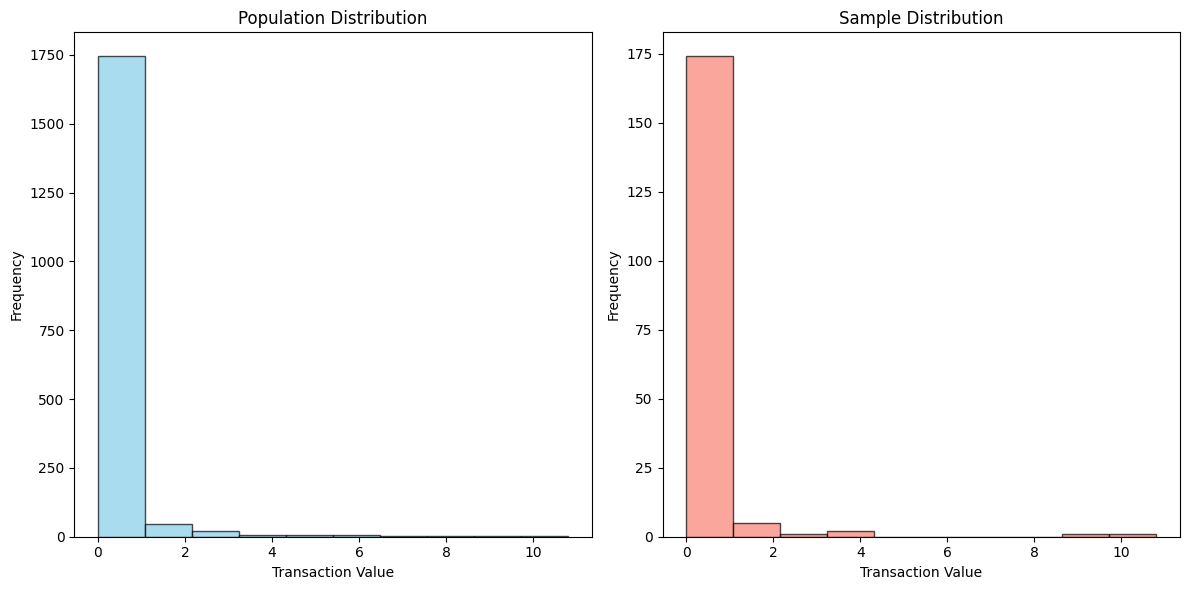

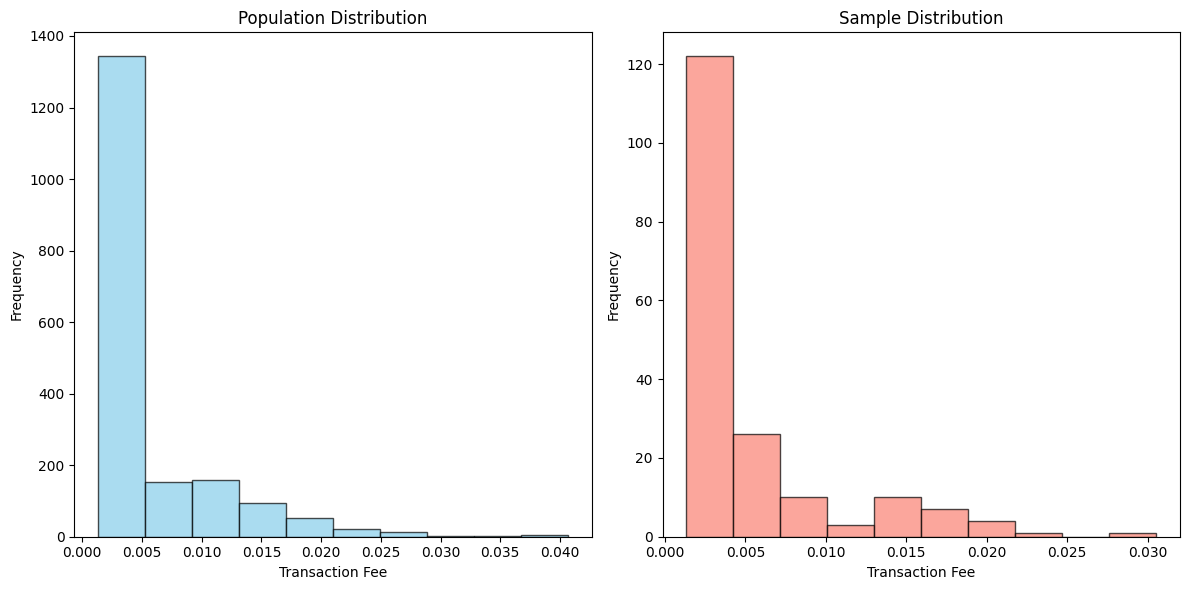

In [81]:
def simple_random_sampling(df, sample_proportion, random_seed):
    return df.sample(frac=sample_proportion, random_state=random_seed, replace=False)

srs_df = simple_random_sampling(df, SAMPLE_PROPORTION, RANDOM_SEED)

plot_distributions(df, srs_df, "Value", "Transaction Value")
plot_distributions(df, srs_df, "Txn Fee", "Transaction Fee")

C:\Users\attar\AppData\Local\Temp\ipykernel_5092\2737865519.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return grouped_df.apply(lambda x: x.sample(frac=sample_proportion, random_state=random_seed, replace=False))


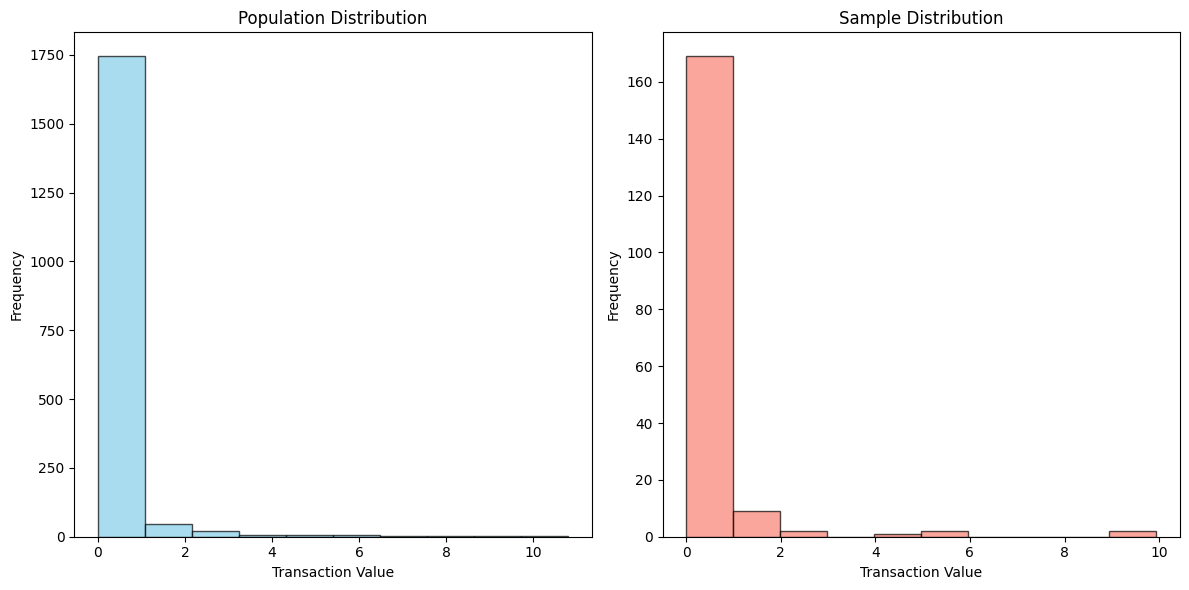

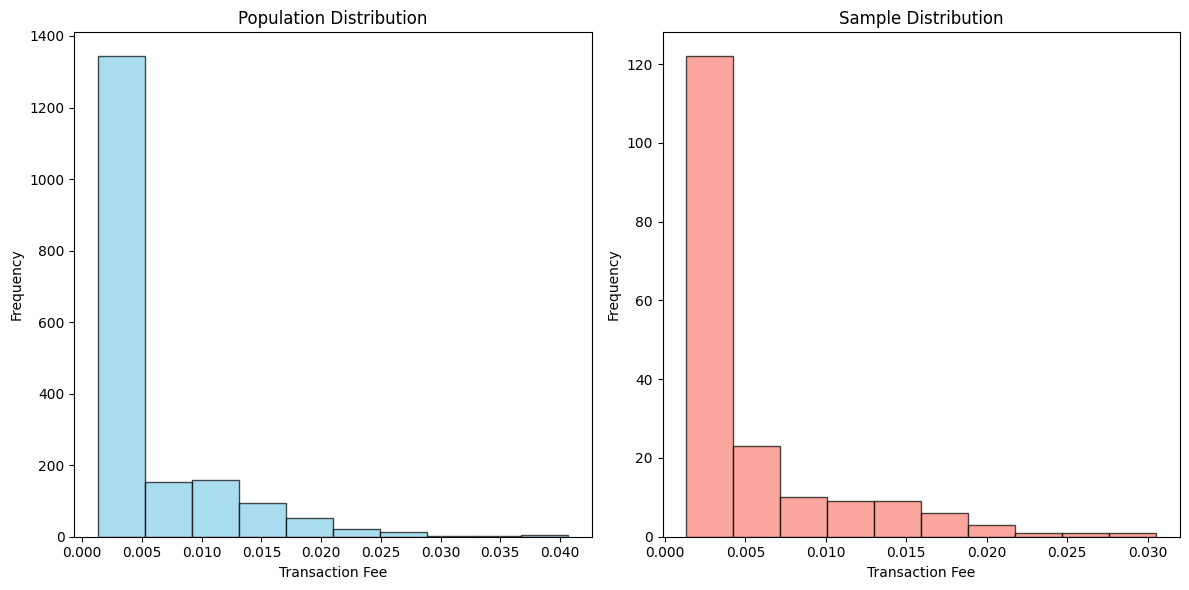

In [82]:
def stratified_sampling(df, characteristic="Block", sample_proportion=0.1, random_seed=42):
    grouped_df = df.groupby(characteristic)
    return grouped_df.apply(lambda x: x.sample(frac=sample_proportion, random_state=random_seed, replace=False))

stratified_df = stratified_sampling(df, "Block", SAMPLE_PROPORTION, RANDOM_SEED)

plot_distributions(df, stratified_df, "Value", "Transaction Value")
plot_distributions(df, stratified_df, "Txn Fee", "Transaction Fee")

## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Steps

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by handling missing values, converting data types, and removing any irrelevant information.

3. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.

4. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. Explain what you have stratified the data by and why you chose this column.

5. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.

6. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.

### Considerations

-   **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
-   **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.

Explain the above considerations in your report.


In [83]:
# Your code here

### Resources

-   [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
-   [Selenium Documentation](https://selenium-python.readthedocs.io/)
-   [Pandas Documentation](https://pandas.pydata.org/docs/)
-   [Ethereum](https://ethereum.org/en/)